# Analyze results




In [1]:
import sys
from pathlib import Path
import re
from os import getenv
import pandas as pd
import numpy as np
from openai import OpenAI
import pickle

repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 
from yaml_utils import load_yaml

# Load all_bayesian_networks from disk
with open("bns.pkl", "rb") as f:
    all_bayesian_networks = pickle.load(f)

# Load df from CSV
df = pd.read_csv("bns_metadata.csv")

# Read the full_df DataFrame from a CSV file
full_df = pd.read_csv("queries.csv")
print("Loaded DataFrame from 'queries.csv'")
print(full_df.head())

Loaded DataFrame from 'queries.csv'
   achieved_tw     naming  alpha  seed  variant_index  num_edges  num_nodes  \
0            3  confusing    1.0    42              0          6          4   
1            3  confusing    1.0    42              0          6          4   
2            3  confusing    1.0    42              0          6          4   
3            3  confusing    1.0    42              0          6          4   
4            3  confusing    1.0    42              0          6          4   

   num_nodes/num_edges  avg_markov_blanket_size  bn_index  ...  \
0             0.666667                      3.0         0  ...   
1             0.666667                      3.0         0  ...   
2             0.666667                      3.0         0  ...   
3             0.666667                      3.0         0  ...   
4             0.666667                      3.0         0  ...   

   avg_markov_blanket_size_target min_distance_target_evidence  \
0                         

In [2]:
import pandas as pd

# Read the full DataFrame from csv
csv_path = Path("llm_responses.csv")
full_df = pd.read_csv(csv_path)


In [3]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)

Found 15 rows with LLM probability values:


,achieved_tw,naming,alpha,seed,variant_index,num_edges,num_nodes,num_nodes/num_edges,avg_markov_blanket_size,bn_index,...,all_evidence_are_roots,all_evidence_are_leaves,all_target_are_roots,all_target_are_leaves,abs_diff,rel_diff,llm_probability,llm_response,model,date
45,3,confusing,1.0,44,0,10,6,0.600000,5.000000,2,...,False,False,False,False,0.110986,-0.554257,0.0903,"Final Answer: P(U_9d6udx=s0, M_clcji8=s0 | X_w...",openai/o3-mini-high,2025-11-02
101,4,confusing,1.0,50,0,19,8,0.421053,5.750000,8,...,False,False,False,False,0.123688,0.413057,0.3602,"Final Answer: P(A_dcka33=s1, A_l40h2y=s1 | O_n...",openai/o3-mini-high,2025-11-02
106,4,confusing,1.0,50,0,19,8,0.421053,5.750000,8,...,False,False,False,True,0.155729,0.234510,0.7541,"Final Answer: P(O_nhaatt=s1 | A_dcka33=s0, G_u...",openai/o3-mini-high,2025-11-02
111,4,confusing,0.5,51,0,19,8,0.421053,5.750000,9,...,False,False,False,False,0.556378,-0.845710,0.3661,"Final Answer: P(A_dcka33=s1 | G_u5vagt=s0, C_p...",openai/o3-mini-high,2025-11-02
118,4,confusing,0.5,51,0,19,8,0.421053,5.750000,9,...,False,False,False,False,0.117568,0.218479,0.3337,"Final Answer: P(C_p490cm=s1, G_u5vagt=s1 | O_n...",openai/o3-mini-high,2025-11-02
122,6,confusing,1.0,52,0,25,8,0.320000,6.750000,10,...,False,False,False,False,0.182190,0.398907,0.4593,"Final Answer: P(G_zwp5v0=s0 | W_zz5knb=s0, V_o...",openai/o3-mini-high,2025-11-02
125,6,confusing,1.0,52,0,25,8,0.320000,6.750000,10,...,False,False,False,False,0.180357,-0.295512,0.0812,"Final Answer: P(B_97fqlp=s1, V_2lnxw2=s0 | G_z...",openai/o3-mini-high,2025-11-02
152,4,confusing,0.5,57,0,21,10,0.476190,7.800000,15,...,True,False,False,False,0.114993,-0.240676,0.3627,"Final Answer: P(D_vyqi2q=s1, R_3o4z3k=s1 | E_0...",openai/o3-mini-high,2025-11-02
173,3,confusing,0.5,61,0,16,12,0.750000,4.166667,19,...,False,False,False,True,0.484484,-0.984579,0.0076,"Final Answer: P(L_u8nlyj=s1 | X_fb1gu5=s0, N_b...",openai/o3-mini-high,2025-11-02
179,4,confusing,0.5,63,0,19,12,0.631579,5.000000,21,...,False,True,True,False,0.121484,-0.132825,0.8090,Final Answer: P(S_yrjlr4=s0 | T_bprvfu=s0) = 0...,openai/o3-mini-high,2025-11-02


In [4]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

LLM Performance Analysis:
Successful LLM responses: 15/237 (6.3%)


In [5]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']])
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")


import matplotlib.pyplot as plt

if 'plot_df' in locals() and not plot_df.empty and 'abs_error' in plot_df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(plot_df['abs_error'], bins=20, color='skyblue', edgecolor='k')
    plt.title('Histogram of Absolute Error (LLM vs Exact)')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No data available for plotting histogram of absolute error.")


Accuracy Metrics (for 15 successful responses):
Mean Absolute Error: 0.141246
Mean Relative Error: 0.473124
Max Absolute Error: 0.348764
Max Relative Error: 2.606727


,query_vars,query_states,evidence,probability,llm_probability,abs_error
45,"[np.str_('U_9d6udx'), np.str_('M_clcji8')]","['s0', 's0']","{np.str_('X_wzdhd9'): 's0', np.str_('K_5si3ik'...",0.089257,0.0903,0.001043
101,"[np.str_('A_dcka33'), np.str_('A_l40h2y')]","['s1', 's1']","{np.str_('O_nhaatt'): 's0', np.str_('G_u5vagt'...",0.423133,0.3602,0.062933
106,[np.str_('O_nhaatt')],['s1'],"{np.str_('A_dcka33'): 's0', np.str_('G_u5vagt'...",0.819791,0.7541,0.065691
111,[np.str_('A_dcka33')],['s1'],"{np.str_('G_u5vagt'): 's0', np.str_('C_p490cm'...",0.101505,0.3661,0.264595
118,"[np.str_('C_p490cm'), np.str_('G_u5vagt')]","['s1', 's1']","{np.str_('O_nhaatt'): 's1', np.str_('F_gwfc5h'...",0.655686,0.3337,0.321986
122,[np.str_('G_zwp5v0')],['s0'],"{np.str_('W_zz5knb'): 's0', np.str_('V_oukabs'...",0.638913,0.4593,0.179613
125,"[np.str_('B_97fqlp'), np.str_('V_2lnxw2')]","['s1', 's0']","{np.str_('G_zwp5v0'): 's0', np.str_('W_zz5knb'...",0.429964,0.0812,0.348764
152,"[np.str_('D_vyqi2q'), np.str_('R_3o4z3k')]","['s1', 's1']",{np.str_('E_0ymclq'): 's1'},0.362797,0.3627,0.000097
173,[np.str_('L_u8nlyj')],['s1'],"{np.str_('X_fb1gu5'): 's0', np.str_('N_bgkp9i'...",0.007588,0.0076,0.000012
179,[np.str_('S_yrjlr4')],['s0'],{np.str_('T_bprvfu'): 's0'},0.793131,0.8090,0.015869


No data available for plotting histogram of absolute error.


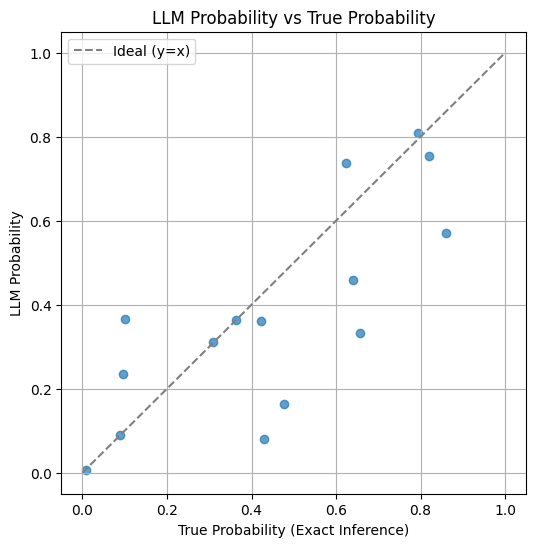

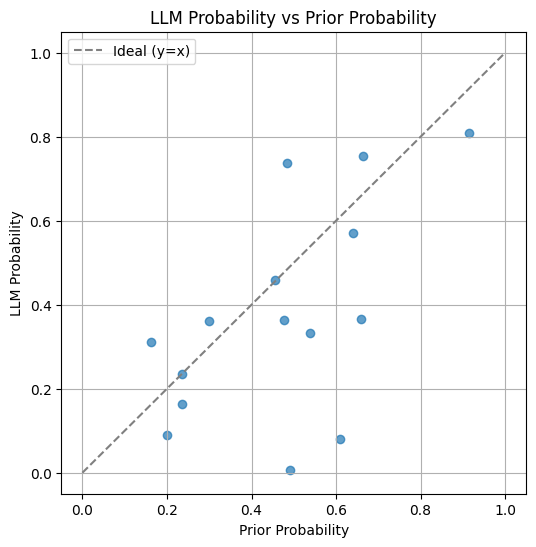

In [6]:
import matplotlib.pyplot as plt

# Plot LLM probability vs true probability (exact inference)
if len(successful_df) > 0:
    plt.figure(figsize=(6, 6))
    plt.scatter(successful_df['probability'], successful_df['llm_probability'], alpha=0.7)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    plt.xlabel('True Probability (Exact Inference)')
    plt.ylabel('LLM Probability')
    plt.title('LLM Probability vs True Probability')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data for LLM vs True Probability plot.")

# Check for prior probability column; if not, try to compute it
prior_col = None
if 'prior_probability' in successful_df.columns:
    prior_col = 'prior_probability'
elif 'prior' in successful_df.columns:   # fallback if named differently
    prior_col = 'prior'
else:
    # Try to estimate prior as mean for that query variable across evidence-free rows if available
    # Otherwise, skip
    pass

# Plot LLM probability vs prior probability (if available)
if prior_col is not None and prior_col in successful_df.columns:
    plt.figure(figsize=(6, 6))
    plt.scatter(successful_df[prior_col], successful_df['llm_probability'], alpha=0.7)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    plt.xlabel('Prior Probability')
    plt.ylabel('LLM Probability')
    plt.title('LLM Probability vs Prior Probability')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No prior probability column found for LLM vs Prior plot.")


/tmp/ipykernel_23558/4043295967.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_23558/4043295967.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_23558/4043295967.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_23558/4043295967.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_2

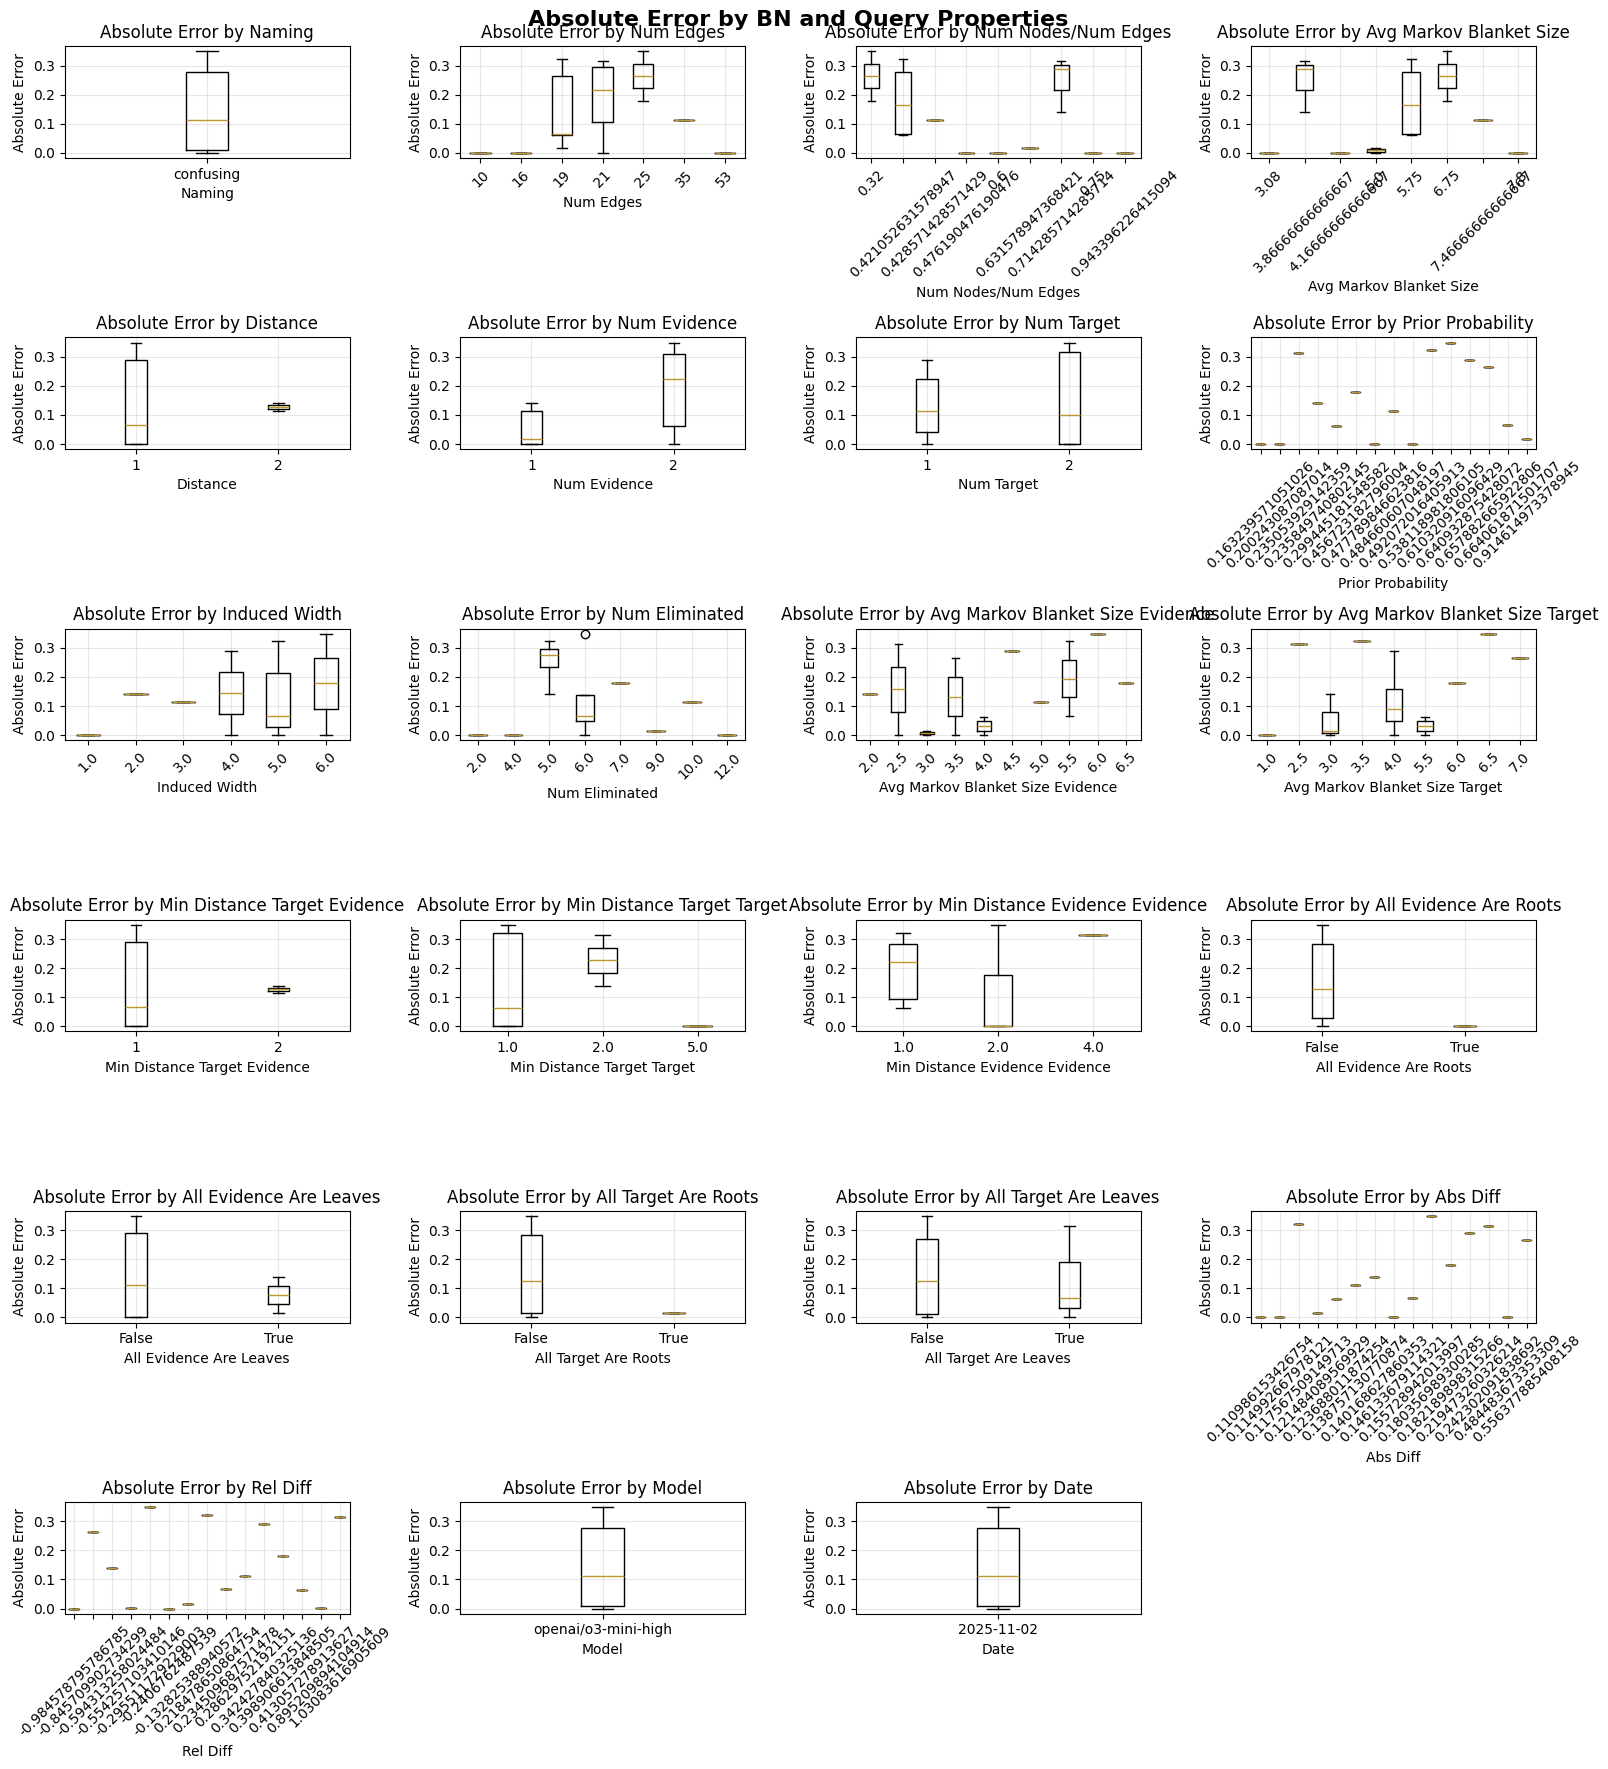


Summary Statistics by Property:

NAMING:
           count      mean       std       min       max
naming                                                  
confusing     15  0.141246  0.134097  0.000012  0.348764

NUM_EDGES:
           count      mean       std       min       max
num_edges                                               
10             1  0.001043       NaN  0.001043  0.001043
16             1  0.000012       NaN  0.000012  0.000012
19             5  0.146215  0.137222  0.015869  0.321986
21             4  0.185945  0.145810  0.000097  0.314156
25             2  0.264189  0.119608  0.179613  0.348764
35             1  0.113182       NaN  0.113182  0.113182
53             1  0.001227       NaN  0.001227  0.001227

NUM_NODES/NUM_EDGES:
                     count      mean       std       min       max
num_nodes/num_edges                                               
0.320000                 2  0.264189  0.119608  0.179613  0.348764
0.421053                 4  0.178801  0

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = successful_df.copy()

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")


In [20]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Prepare features and target
# Exclude 'abs_error' and 'rel_error' and other "unpredictable" cols
target_col = 'abs_error'
exclude_cols = ['abs_error', 'rel_error', 'llm_probability'] if 'rel_error' in plot_df.columns else ['abs_error', 'llm_probability']

# Drop instances (rows) with NaNs in 'induced_width', 'num_eliminated'
cols_to_check = ['induced_width', 'num_eliminated']
plot_df = plot_df.dropna(subset=cols_to_check)

# Drop columns: 'min_distance_target_target' and 'min_distance_evidence_evidence' if they are present
cols_to_drop = ['min_distance_target_target', 'min_distance_evidence_evidence']
cols_to_drop_actual = [col for col in cols_to_drop if col in plot_df.columns]
if cols_to_drop_actual:
    plot_df = plot_df.drop(columns=cols_to_drop_actual)

# Ensure to drop index columns as well if present (e.g., pandas index)
feature_cols = [col for col in plot_df.columns 
                if col not in exclude_cols and not (isinstance(col, str) and col.startswith('Unnamed'))]
print(feature_cols)

feature_cols = ['num_nodes/num_edges', 'distance', 'num_evidence', 'num_target', 'induced_width', 'num_eliminated']

X = plot_df[feature_cols]
y = plot_df[target_col]

# Detect categorical vs numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Add types that are lists/dicts, which aren't directly usable and may need to be dropped or stringified
non_numeric_cols = X.columns[X.applymap(type).nunique() > 1].tolist()
# For simplicity, also treat any column that isn't float/int as categorical (they may be strings from lists/sets)
for col in X.columns:
    if (col not in categorical_cols 
        and not np.issubdtype(X[col].dtype, np.number)):
        categorical_cols.append(col)

# Remove columns with unhashable types (e.g., lists, dicts) from predictors
# Or convert them to string representation (useful for variables like 'query_vars'/'evidence')
def safe_stringify(x):
    try:
        return str(x)
    except Exception:
        return "NA"

for col in categorical_cols:
    X[col] = X[col].apply(safe_stringify)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in X.columns if col not in categorical_cols]),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42, max_iter=5000))
])

# Fit
lasso_pipe.fit(X_train, y_train)

# Output results
print("Best alpha found by cross-validation:", lasso_pipe.named_steps['regressor'].alpha_)
print("Lasso Train R^2:", lasso_pipe.score(X_train, y_train))
print("Lasso Test R^2:", lasso_pipe.score(X_test, y_test))

# Optionally, get coefficients and the feature names
feature_names = []
num_cols = [col for col in X.columns if col not in categorical_cols]
feature_names.extend(num_cols)
if categorical_cols:
    cat_encoder = lasso_pipe.named_steps['preprocessor'].named_transformers_['cat']
    cat_names = cat_encoder.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_names)

coefs = lasso_pipe.named_steps['regressor'].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
print("\nNon-zero Lasso coefficients:")
print(coef_df.loc[coef_df['coef'] != 0].sort_values('coef', key=abs, ascending=False))


['achieved_tw', 'naming', 'alpha', 'seed', 'variant_index', 'num_edges', 'num_nodes', 'num_nodes/num_edges', 'avg_markov_blanket_size', 'bn_index', 'query_index', 'query_vars', 'query_states', 'evidence', 'distance', 'num_evidence', 'num_target', 'probability', 'prior_probability', 'induced_width', 'num_eliminated', 'avg_markov_blanket_size_evidence', 'avg_markov_blanket_size_target', 'min_distance_target_evidence', 'all_evidence_are_roots', 'all_evidence_are_leaves', 'all_target_are_roots', 'all_target_are_leaves', 'abs_diff', 'rel_diff', 'llm_response', 'model', 'date']


/tmp/ipykernel_23558/1378581727.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_cols = X.columns[X.applymap(type).nunique() > 1].tolist()


Best alpha found by cross-validation: 0.07052536309900884
Lasso Train R^2: 0.0
Lasso Test R^2: -0.0661373004301069

Non-zero Lasso coefficients:
               feature          coef
0  num_nodes/num_edges -1.009294e-17


/home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-05, tolerance: 1.438e-05
  model = cd_fast.enet_coordinate_descent_gram(
/home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-05, tolerance: 1.438e-05
  model = cd_fast.enet_coordinate_descent_gram(
/home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: Co

In [39]:
nan_columns = successful_df.columns[successful_df.isnull().any()].tolist()
print("Columns with NaNs in success df:", nan_columns)
nan_rows = successful_df.loc[successful_df[['induced_width', 'num_eliminated']].isnull().any(axis=1)]
print("Rows with NaNs in 'induced_width' or 'num_eliminated':")
display(nan_rows)

induced_width_nan_indices = successful_df[successful_df['induced_width'].isnull()].index.tolist()
num_eliminated_nan_indices = successful_df[successful_df['num_eliminated'].isnull()].index.tolist()

print("Indices with NaN in 'induced_width':", induced_width_nan_indices)
print("Indices with NaN in 'num_eliminated':", num_eliminated_nan_indices)

successful_df.index
print(full_df.index)
#full_df[204, 'induced_width']
# This line is invalid Python syntax. 
# If your intention is to get the column names of full_df, use:
# This is invalid in pandas; use .loc or .iloc. For column selection by name, use:
full_df.loc[204, 'bn_index']

row = full_df.iloc[ridx]
bn = all_bayesian_networks[int(row['bn_index'])]['bn']
query_vars = _parse_field(row['query_vars']) or []
query_states = _parse_field(row['query_states']) or []
evidence = _parse_field(row['evidence']) or None




Columns with NaNs in success df: ['induced_width', 'num_eliminated', 'min_distance_target_target', 'min_distance_evidence_evidence']
Rows with NaNs in 'induced_width' or 'num_eliminated':


,achieved_tw,naming,alpha,seed,variant_index,num_edges,num_nodes,num_nodes/num_edges,avg_markov_blanket_size,bn_index,...,all_target_are_roots,all_target_are_leaves,abs_diff,rel_diff,llm_probability,llm_response,model,date,abs_error,rel_error
204,3,confusing,0.5,67,0,21,15,0.714286,3.866667,25,...,False,True,0.242302,1.030836,0.1632,"Final Answer: P(M_oqwcdv=s0, C_28dcjw=s1 | D_p...",openai/o3-mini-high,2025-11-02,0.314156,0.658117


Indices with NaN in 'induced_width': [204]
Indices with NaN in 'num_eliminated': [204]
RangeIndex(start=0, stop=237, step=1)


np.int64(25)

In [60]:
from experiments.bn_query_sweep import _parse_field, call_llm_for_query
ridx = 204
#print(full_df.iloc[ridx, ]) 

row = full_df.iloc[ridx]
bn = all_bayesian_networks[int(row['bn_index'])]['bn']
query_vars = _parse_field(row['query_vars']) or []
query_states = _parse_field(row['query_states']) or []
evidence = _parse_field(row['evidence']) or None

from bn_utils import compute_query_complexity
print(query_vars)
#print(query_states)
print(list(evidence.keys()))
print(bn.nodes())
print(query_vars[0] in bn.nodes())

compute_query_complexity(bn, query_vars, list(evidence.keys()), verbose=True)


['M_oqwcdv', 'C_28dcjw']
['D_pynyh4', 'A_ox6gtq']
['U_np0vkn', 'C_bc0kor', 'O_2bgl1k', 'Q_n31l50', 'Z_4wk5gk', 'M_qb3vu2', 'E_mluyxo', 'I_x9d51b', 'C_28dcjw', 'M_oqwcdv', 'M_j2m8h9', 'D_pynyh4', 'A_h44rw8', 'K_6sscg6', 'A_ox6gtq']
True
Original network: 15 nodes, 21 edges
Found 4 independent variables: ['A_h44rw8', 'K_6sscg6', 'M_qb3vu2', 'Z_4wk5gk']
After removing independent variables: 11 nodes, 15 edges
Found 2 barren variables: ['C_bc0kor', 'O_2bgl1k']
Removing 6 variables (independent: 4, barren: 2), keeping 9 variables
Variables to keep: ['A_ox6gtq', 'C_28dcjw', 'D_pynyh4', 'E_mluyxo', 'I_x9d51b', 'M_j2m8h9', 'M_oqwcdv', 'Q_n31l50', 'U_np0vkn']
Reduced network: 9 nodes, 10 edges


ValueError: The state names of A_ox6gtq doesn't match in it's child nodes.